# PlasticParcels DRAKKAR Tutorial
In this tutorial we will introduce you to some of the basic Parcels functions, as well as utilise the PlasticParcels tool for simulating microplastic pollution in the Mediterranean sea.

By the end of this tutorial you should be able to create and visual hydrodynamic (and other) fields, create particle sets that represent marine microplastic pollution release locations, and apply physics parameterisations to simulate the dispersal of microplastics in the ocean.

We will start by importing a number of necessary packages.

In [1]:
## Library imports
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Parcels and PlasticParcels imports
from parcels import ParticleFile
from helper import create_fieldset, create_particleset, create_kernel, load_default_settings, create_particleset_from_file, load_test_settings
#from utils import select_files, create_directory, getclosest_ij

## Plotting imports
import matplotlib.pyplot as plt
import cartopy.crs as ccrs



# Model settings
Using PlasticParcels, we will load the default settings for our sumulations, using the `load_default_settings` function.

This returns two dictionary of parameters, one used for fieldset creation, the other for particleset creation.

You can update the parameters by updating the dictionaries as necessary.

The description of each parameter can be found in the PlasticParcels/helper.py file.

In [2]:
## Load the default model and particle settings
model_settings, particle_settings = load_test_settings() #load_default_settings()

In [3]:
## View settings
model_settings

{'input_data_dir': '../../data/input_data/',
 'input_data_dir_2': '../../data/input_data/',
 'input_data_dir_3': '../../data/input_data/',
 'mode': '3D',
 'ocean_dir': 'MOi/psy4v3r1/',
 'ocean_filename': 'psy4v3r1-daily_',
 'ocean_mesh': 'MOi/domain_ORCA0083-N006/coordinates.nc',
 'bathymetry_mesh': 'MOi/domain_ORCA0083-N006/bathymetry_ORCA12_V3.3.nc',
 'mixing_f': True,
 'biofouling_f': True,
 'bgc_dir': 'MOi/biomer4v2r1/',
 'bgc_filename': 'biomer4v2r1-weekly_',
 'bgc_mesh': 'MOi/domain_ORCA025-N006/mesh_hgr_PSY4V3_deg.nc',
 'bgc_biofilm_density': 1388.0,
 'bgc_algae_cell_volume': 2e-16,
 'bgc_boltzmann_constant': 1.3805834190672156e-23,
 'bgc_respiration_rate': 1.1574074074074074e-06,
 'bgc_respiration_temperature_coefficient': 2.13,
 'bgc_shear_frequency': 2.0,
 'bgc_carbon_atomic_weight': 12.0,
 'bgc_collision_probability': 1.0,
 'bgc_algae_mortality_rate': 1.0,
 'bgc_algae_respiration_f': 1.0,
 'stokes_f': True,
 'stokes_dir': 'ERA5/waves/',
 'stokes_filename': 'ERA5_global_waves

In [4]:
## Update settings

# e.g. turn off Stokes Drift
#model_settings['stokes_f'] = False

#model_settings['mode'] = '2D'
#model_settings['mixing_f'] = False
#model_settings['biofouling_f'] = False
#model_settings['wind_f'] = False

# Create a Parcels fieldset
We now create the fieldset that contains all the required fields (ocean velocities, temperature and salinity, ocean biology, winds and waves, etc.).

We loaded the default settings above, which we will pass into the `create_fieldset` PlasticParcels function. This removes a lot of the complexity when creating fieldsets with a large number of underlying fields. What is produced is a Parcels fieldset object.

In [5]:
fieldset = create_fieldset(model_settings, particle_settings)

print("Time origin of data: ", fieldset.time_origin)

Time origin of data:  2019-01-09T12:00:00.000000000


To list all the fields that are present we use `.get_fields()` method to return a list of the fields, which we can then utilise and analyse.

In [6]:
for parcels_field in fieldset.get_fields():
    print(parcels_field.name)

U
V
W
conservative_temperature
absolute_salinity
UV
UVW
bathymetry
mixing_kz
pp_phyto
bio_nanophy
bio_diatom
Stokes_U
Stokes_V
wave_Tp
Wind_U
Wind_V
unbeach_U
unbeach_V


## Plotting Parcels `fields`
Parcels fields are not loaded into memory immediately, rather the fields are only loaded when they are required (deferred load). Often the hydrodynamic data alone can be hundreds of GBs. To visualise these fields we can load in the first timestep of data.

We do this using the `.computeTimeChunk(time, dt)` method, which takes as input a model time to load, and a number of timesteps to load. Once loaded, we plot the resulting fields using the `pcolormesh` matplotlib function. Below is a small snippet of code used to plot these fields.

**A key highlight here is that Parcels handles different spatial grids and temporal resolutions automatically, and can even use different interpolation methods on each.**


<div class="alert alert-info">
Note - The plots below are indicative only. Since the data is on a C-grid, and the plotting assumes we are passing T-points, there is a slight spatial shift to the data. This is only an issue with our basic plotting below, Parcels correctly interprets the grids.
</div>

In [7]:
## Load data into memory
fieldset.computeTimeChunk(0,1)

21600

In [8]:
## Plotting function
def plot_field(lons, lats, data, title):
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    colors = ax.pcolormesh(lons, lats, data, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    plt.title(title)
    plt.colorbar(colors)
    plt.show()


Note that some fields have no depth component (e.g. bathymetry, wind, waves), and so the shape of their data is different, and should be indexed differently.

In [9]:
print("The usual shape order is (time, depth, latitude, longitude)")
print("Ocean U velocity data shape:", fieldset.U.data.shape)
print("Ocean V velocity data shape:", fieldset.V.data.shape)
print("Wind U velocity data shape:", fieldset.Wind_U.data.shape)
print("Wind V velocity data shape:", fieldset.Wind_U.data.shape)
print("Bathymetry shape:", fieldset.bathymetry.data.shape)

The usual shape order is (time, depth, latitude, longitude)
Ocean U velocity data shape: (2, 50, 503, 489)
Ocean V velocity data shape: (2, 50, 503, 489)
Wind U velocity data shape: (2, 721, 1450)
Wind V velocity data shape: (2, 721, 1450)
Bathymetry shape: (1, 3059, 4322)


Plot the ocean surface velocity fields

/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


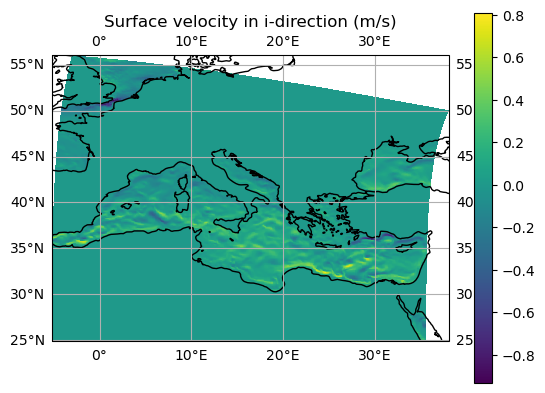

/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


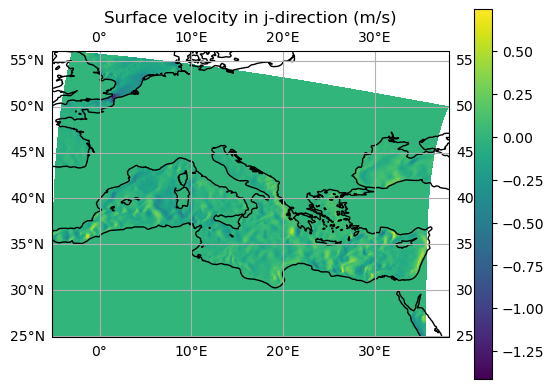

In [10]:
## Plot velocity fields
plot_field(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0,0], "Surface velocity in i-direction (m/s)")
plot_field(fieldset.V.grid.lon, fieldset.V.grid.lat, fieldset.V.data[0,0], "Surface velocity in j-direction (m/s)")

<div class="alert alert-info">
Note: The U,V fields are on a curvilinear grid, and the velocities are in the i- and j-directions. Parcels automatically rotates these vectors into the zonal- and meridional-directions when performing interpolation.
</div>

Plot the model bathymetry field

/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


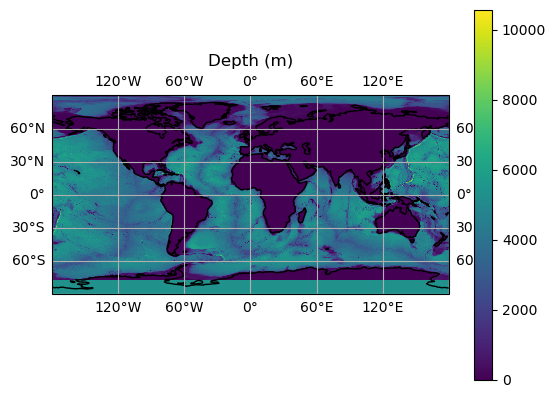

In [11]:
## Plot bathymetry
plot_field(fieldset.bathymetry.grid.lon, fieldset.bathymetry.grid.lat, fieldset.bathymetry.data[0], "Depth (m)")

Plot the 10m-wind velocity fields

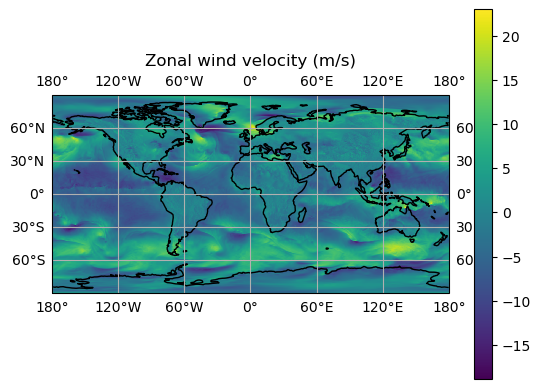

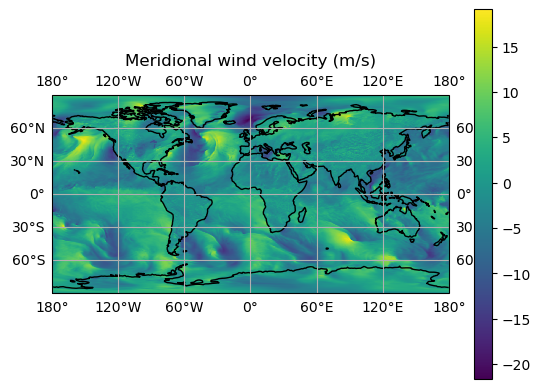

In [12]:
## Plot Wind velocity fields
plot_field(fieldset.Wind_U.grid.lon, fieldset.Wind_U.grid.lat, fieldset.Wind_U.data[0], "Zonal wind velocity (m/s)")
plot_field(fieldset.Wind_V.grid.lon, fieldset.Wind_V.grid.lat, fieldset.Wind_V.data[0], "Meridional wind velocity (m/s)")

Plot vertical eddy diffusivity

/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


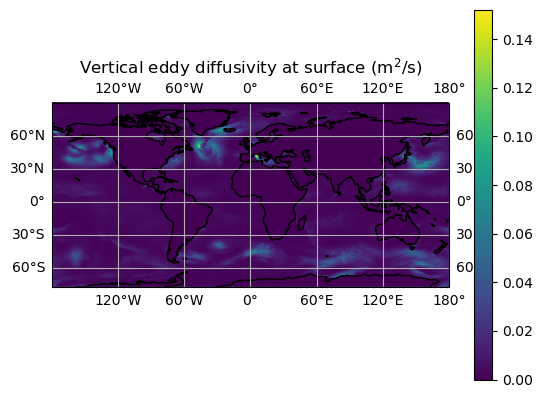

In [13]:
## Plot Vertical Diffusivity field
plot_field(fieldset.mixing_kz.grid.lon, fieldset.mixing_kz.grid.lat, fieldset.mixing_kz.data[0,0], "Vertical eddy diffusivity at surface (m$^2$/s)")

Plot biology related fields

/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


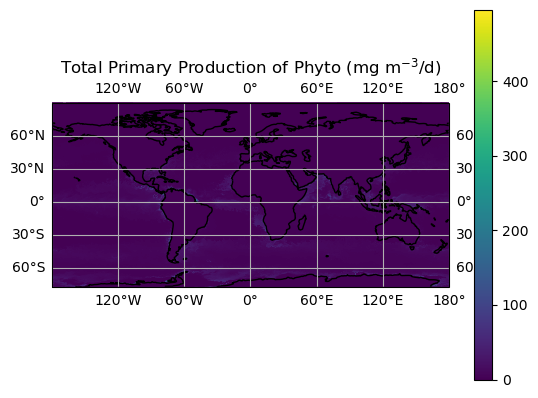

/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


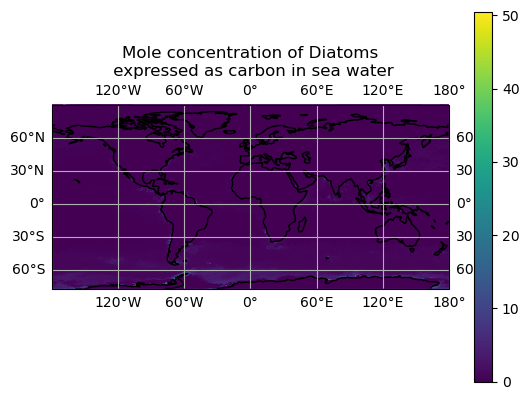

/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


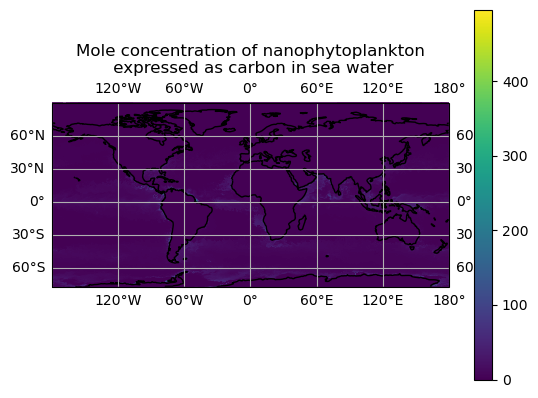

In [14]:
## Plot pp_phyto
plot_field(fieldset.pp_phyto.grid.lon, fieldset.pp_phyto.grid.lat, fieldset.pp_phyto.data[0,0], "Total Primary Production of Phyto (mg m$^{-3}$/d)")
plot_field(fieldset.bio_diatom.grid.lon, fieldset.bio_diatom.grid.lat, fieldset.bio_diatom.data[0,0], "Mole concentration of Diatoms\n expressed as carbon in sea water")
plot_field(fieldset.pp_phyto.grid.lon, fieldset.pp_phyto.grid.lat, fieldset.pp_phyto.data[0,0], "Mole concentration of nanophytoplankton\n expressed as carbon in sea water")

# Parcels can also be used as a standalone field interpolator
There are two ways to access the data in each Parcels field object. Firstly, as above, accessing the data directly and using the grid indices directly.

Another way to access the field data is to pass the field a (time, depth, latitude, longitude) tuple, from which Parcels will interpolate the data for you.

<div class="alert alert-info">
Note: The U,V fields are on a curvilinear grid, and the velocities are in the i- and j-directions. The UV field is a Parcels VectorField which references the U and V fields, appropriately rotating and scaling the i/j-vectors into zonal- and meridional-directions. Other velocity fields (e.g. wind) need their units to be converted when loaded as a field.
</div>


In [15]:
# Sample the U,V ocean velocities at the ocean surface somewhere in the Mediterranean
poi = [35.25, 20.11] # Point of Interest: 35.25deg North, 20.11deg East

U_value = fieldset.U[0,0,poi[0],poi[1]]
V_value = fieldset.V[0,0,poi[0],poi[1]]
print("Surface velocities in the i-, j-directions:", U_value, V_value, " (degrees/s).")

U_value, V_value = fieldset.UV[0,0,poi[0],poi[1]]
print("Surface velocities in the zonal-, meridional-directions:", U_value, V_value, " (degrees/s)")

Surface velocities in the i-, j-directions: 1.1433753050420808e-06 2.699197438271291e-07  (degrees/s).
Surface velocities in the zonal-, meridional-directions: 1.2040195495488277e-06 2.0662101712086765e-07  (degrees/s)


We can also convert the values back into units of m/s by using the applyConversion parameter

In [16]:
U_value, V_value = fieldset.UV.eval(0, 0, poi[0],poi[1], applyConversion=False)
print("Surface velocities in the zonal-, meridional-directions:", U_value, V_value, " (m/s)")

Surface velocities in the zonal-, meridional-directions: 0.10925900639782332 0.01874986750837481  (m/s)


In [17]:
## Determine the ocean depth at the point of interest
print(fieldset.bathymetry[0,0,poi[0], poi[1]])

3000.6534811816796


In [18]:
## Determine the wind velocity at the point of interest
Wind_U_value = fieldset.Wind_U[0,0,poi[0],poi[1]]
Wind_V_value = fieldset.Wind_V[0,0,poi[0],poi[1]]
print("Surface wind velocities: ", Wind_U_value, Wind_V_value, " (degrees/s).")

Wind_U_value = fieldset.Wind_U.eval(0, 0, poi[0],poi[1], applyConversion=False)
Wind_V_value = fieldset.Wind_V.eval(0, 0, poi[0],poi[1], applyConversion=False)
print("Surface wind velocities: ", Wind_U_value, Wind_V_value, " (m/s).")

Surface wind velocities:  0.00011394059292790833 -3.408169403103637e-05  (degrees/s).
Surface wind velocities:  10.339562988281248 -3.787157840728762  (m/s).


# Particle Sets
We will now create some particle sets which represent release locations for microplastic particles.

In the first instance, we will create a basic particle set using Parcels. Since our microplastic particles require additional variables (e.g. windage coefficients and settling velocities), we will still use the PlasticParcels helper functions.

In the second instance, we will use PlasticParcels to create more complicated particle sets that replicate likely microplastic release locations. These release locations are determined using a range of datasets.


## Creating a simple particle set
Parcels includes a number of methods to create particle sets.

The most commonly used is `ParticleSet.from_list()`, which allows you to pass through a list of longitudes, latitudes, depths, and times.

Below, we randomly place particles in a box at different depths, and given these particles a wind coefficient, density, and diameter.

In [19]:
## Number of particles to release
n_particles = 100

## Randomly place particle release locations on a grid
lons = np.random.uniform(2,7,n_particles)
lats = np.random.uniform(37,42,n_particles)

## Randomly place the particles between the ocean surface and 50m depth
depths = np.random.uniform(0,50, n_particles)

## Create a dictionary of lists containing release location information 
release_locations = {'lons': lons,
                     'lats': lats,
                     'depths': depths
}

## Define particle properties
wind_coefficient = 0.01 # Percent of wind speed to apply
plastic_density = 1020. # Particle density (kg/m^3)
plastic_diameter = 0.001 # Partice diameter (m)
## Particleset settings
particle_settings.update({'release_locations': release_locations, # A dictionary of lons, lats, depths (optional), and times (optional)
                          'windage_coefficient': wind_coefficient, # A float or Nx1 array of windage coefficients, values in [0,1] [percent of wind speed]
                          'particle_density': plastic_density, # A float or Nx1 array of particle densities [kg m-3]
                          'particle_diameter': plastic_diameter, # A float or Nx1 array of particle lengths [m]
                          'write_output_option': 'none' # Option to write variables. Options: 'none' (default), 'tracer' (saves tracer fields), 'dynamic' (saves all variables that change spatiotemporally), 'all' (saves all variables)
                           })

In [20]:
## Create the particle set, and kernels required for the simulation
pset = create_particleset(fieldset, particle_settings)
kernels = create_kernel(fieldset, pset)

Let's take a look at the particle set

In [21]:
print(pset)

P[0](lon=3.771221, lat=39.503515, depth=43.345195, time=not_yet_set)
P[1](lon=5.577720, lat=39.251959, depth=49.111494, time=not_yet_set)
P[2](lon=4.819888, lat=40.898111, depth=34.197462, time=not_yet_set)
P[3](lon=2.463042, lat=40.904323, depth=34.004823, time=not_yet_set)
P[4](lon=5.747095, lat=40.641584, depth=21.817334, time=not_yet_set)
P[5](lon=6.939831, lat=38.298182, depth=19.003243, time=not_yet_set)
P[6](lon=6.447058, lat=41.253490, depth=21.960000, time=not_yet_set)
P[7](lon=5.157389, lat=40.577960, depth=39.129311, time=not_yet_set)
P[8](lon=3.629572, lat=38.045035, depth=12.934340, time=not_yet_set)
P[9](lon=3.380756, lat=39.323507, depth=25.805328, time=not_yet_set)
P[10](lon=5.534359, lat=39.215742, depth=6.609374, time=not_yet_set)
P[11](lon=6.142117, lat=37.079744, depth=5.906359, time=not_yet_set)
P[12](lon=5.894302, lat=38.947229, depth=3.886524, time=not_yet_set)
P[13](lon=4.770616, lat=41.496627, depth=49.388528, time=not_yet_set)
P[14](lon=6.736214, lat=37.467210

These particle sets can be indexed by particle id

In [22]:
print("Information saved for particle_id = 4:", pset[4])

Information saved for particle_id = 4: P[4](lon=5.747095, lat=40.641584, depth=21.817334, time=not_yet_set)


Plot the particles, and list the kernels that will be used

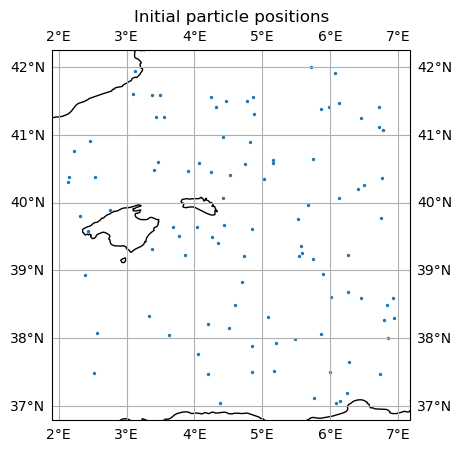

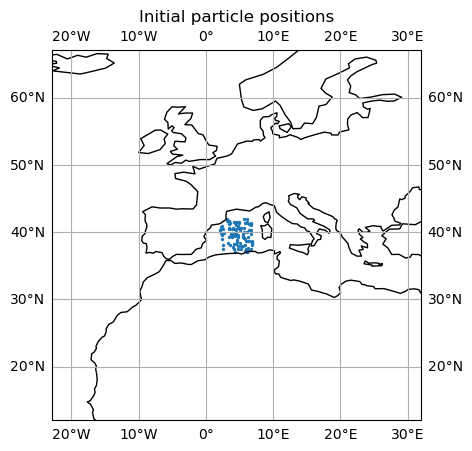

In [23]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(pset.lon, pset.lat, s=2, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title("Initial particle positions")
plt.show()

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(pset.lon, pset.lat, s=2, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_xlim([np.min(pset.lon)-25, np.max(pset.lon)+25])
ax.set_ylim([np.min(pset.lat)-25, np.max(pset.lat)+25])
plt.title("Initial particle positions")
plt.show()

List the kernels that will be used in the particle advection.
For documentation on the kernels, see `PlasticParcels/kernels.py`

In [24]:
kernels

[<function kernels.PolyTEOS10_bsq(particle, fieldset, time)>,
 <function parcels.application_kernels.advection.AdvectionRK4_3D(particle, fieldset, time)>,
 <function kernels.biofouling(particle, fieldset, time)>,
 <function kernels.Stokes_drift(particle, fieldset, time)>,
 <function kernels.windage_drift(particle, fieldset, time)>,
 <function kernels.vertical_mixing(particle, fieldset, time)>,
 <function kernels.unbeaching(particle, fieldset, time)>,
 <function kernels.checkThroughBathymetry(particle, fieldset, time)>,
 <function kernels.checkErrorThroughSurface(particle, fieldset, time)>,
 <function kernels.periodicBC(particle, fieldset, time)>,
 <function kernels.deleteParticle(particle, fieldset, time)>]

We will now advect these particles. We first need to create a Parcels `ParticleFile` where we will store our output. To advect the particles, we simply use the `execute` method.

In [25]:
## Define the runtime, the timestepping, and the output frequency of the simulation
runtime = particle_settings['runtime']
dt_timestep = particle_settings['dt_timestep']
dt_write = particle_settings['dt_write']

## Create the particle file where output will be stored
pfile = ParticleFile('simple_release.zarr', pset, outputdt=dt_write)

## Execute the simulation
pset.execute(kernels, runtime=runtime, dt=dt_timestep, output_file=pfile)


INFO: Output files are stored in simple_release.zarr.
100%|██████████| 259200.0/259200.0 [01:25<00:00, 3038.99it/s]


Plot the final locations of the particles

/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


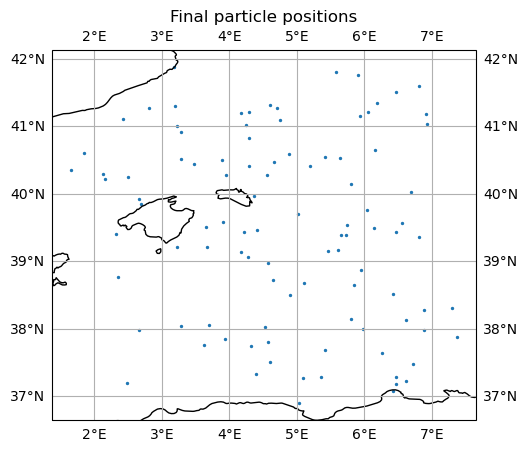

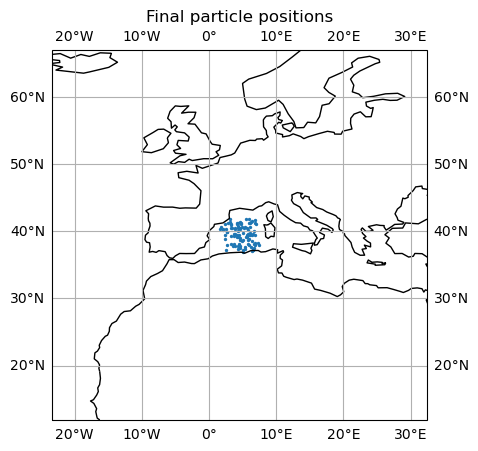

In [26]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(pset.lon, pset.lat, s=2, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title("Final particle positions")
plt.show()

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(pset.lon, pset.lat, s=2, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_xlim([np.min(pset.lon)-25, np.max(pset.lon)+25])
ax.set_ylim([np.min(pset.lat)-25, np.max(pset.lat)+25])
plt.title("Final particle positions")
plt.show()

<div class="alert alert-info">
To analyse the output, you can follow the Parcels tutorial here: https://docs.oceanparcels.org/en/latest/examples/tutorial_output.html
</div>

## Creating a more likely plastic particle release map

### Plastics emitted on the coast
We use the mismanaged plastic waste estimates by country from Jambeck et. al "Plastic waste inputs from land into the ocean", Science (2015) (DOI: 10.1126/science.1260352) combined with the NASA GPW v4.11 global population dataset (see https://sedac.ciesin.columbia.edu/data/set/gpw-v4-population-density-rev11/) and the Natural Earth coastline vector dataset (see https://www.naturalearthdata.com/) in order to create a likely 'coastal' particle release map.


In [27]:
# File locations
coastal = './../../data/release/generated_files/coastal_population_MPW_NEMO0083.csv'
rivers = './../../data/release/generated_files/river_emissions_NEMO0083.csv'
fisheries = './../../data/release/generated_files/agg_data_fisheries_info.csv'

# Read and print coastal dataset
plastic_release = pd.read_csv(coastal)
plastic_release

,Unnamed: 0,Continent,Region,Subregion,Country,Longitude,Latitude,Area[km2],PopulationDensity,Economic status,Mismanaged plastic waste [kg/person/day],MPW_Cell
0,0,Asia,Asia,Western Asia,Yemen,53.583333,12.239176,8.201038,17.718029,LMI,0.076627,11.134375
1,1,Asia,Asia,Western Asia,Yemen,53.666667,12.239176,8.201038,17.718029,LMI,0.076627,11.134375
2,2,Asia,Asia,Western Asia,Yemen,53.750000,12.239176,8.201038,17.718029,LMI,0.076627,11.134375
3,3,Asia,Asia,Western Asia,Yemen,53.833333,12.239176,8.201038,17.718029,LMI,0.076627,11.134375
4,4,Asia,Asia,Western Asia,Yemen,43.416667,12.320603,8.195966,11.842899,LMI,0.076627,7.437719
...,...,...,...,...,...,...,...,...,...,...,...,...
87854,87854,North America,Americas,Caribbean,Sint Maarten,-62.833333,17.869711,7.778406,421.876770,HIC,0.005100,16.735158
87855,87855,North America,Americas,Caribbean,Sint Maarten,-62.666667,17.869711,7.778406,0.000000,HIC,0.005100,0.000000
87856,87856,North America,Americas,Caribbean,Sint Maarten,-62.833333,17.949007,7.771451,421.876770,HIC,0.005100,16.720194
87857,87857,North America,Americas,Caribbean,Sint Maarten,-62.666667,17.949007,7.771451,0.000000,HIC,0.005100,0.000000


### Particles emitted at river outlets
We use the  from Meijer et. al "More than 1000 rivers account for 80% of global riverine plastic emissions into the ocean" Science Advances (2021) (DOI: 10.1126/sciadv.aaz5803) combined with the Natural Earth coastline vector dataset to create a likely 'river' particle release map.


In [28]:
# Read and print coastal dataset
plastic_release = pd.read_csv(rivers)
plastic_release

,Unnamed: 0,Continent,Region,Subregion,Country,Longitude,Latitude,Emissions
0,0,Oceania,Oceania,Australia and New Zealand,New Zealand,168.833333,-46.569603,0.164904
1,1,Oceania,Oceania,Australia and New Zealand,New Zealand,168.333333,-46.454902,0.124932
2,2,Oceania,Oceania,Australia and New Zealand,New Zealand,168.333333,-46.454902,1.213370
3,3,Oceania,Oceania,Australia and New Zealand,New Zealand,168.000000,-46.339961,0.121138
4,4,Oceania,Oceania,Australia and New Zealand,New Zealand,169.833333,-46.397461,0.197533
...,...,...,...,...,...,...,...,...
31814,31814,Europe,Europe,Eastern Europe,Russian Federation,158.768783,52.970829,3.937440
31815,31815,Europe,Europe,Eastern Europe,Russian Federation,158.598172,52.908962,3.821710
31816,31816,Europe,Europe,Eastern Europe,Russian Federation,158.768783,52.970829,9.836130
31817,31817,Europe,Europe,Eastern Europe,Russian Federation,158.598172,52.908962,1.693040


### Particles emitted from fishing-related activity
Lastly, we use the Global Fishing Watch public fishing effort dataset (see https://globalfishingwatch.org/data-download/datasets/public-fishing-effort) combined with the Natural Earth coastline vector dataset to create a likely 'fisheries' particle release map.

In [29]:
# Read and print coastal dataset
plastic_release = pd.read_csv(fisheries)
plastic_release

,Unnamed: 0,Latitude,Longitude,flag,geartype,month,fishing_hours,Continent,Region,Subregion,Country
0,0,-77.84,-177.56,NZL,set_longlines,2020-01-01,0.0336,Oceania,Oceania,Australia and New Zealand,New Zealand
1,1,-77.83,-177.66,NZL,set_longlines,2020-01-01,0.0830,Oceania,Oceania,Australia and New Zealand,New Zealand
2,2,-77.83,-177.65,NZL,set_longlines,2020-01-01,0.9102,Oceania,Oceania,Australia and New Zealand,New Zealand
3,3,-77.83,-177.57,NZL,set_longlines,2020-01-01,0.0836,Oceania,Oceania,Australia and New Zealand,New Zealand
4,4,-77.83,-177.56,NZL,set_longlines,2020-01-01,0.0652,Oceania,Oceania,Australia and New Zealand,New Zealand
...,...,...,...,...,...,...,...,...,...,...,...
54437360,54437360,81.69,35.01,EST,trawlers,2020-10-01,0.0333,Europe,Europe,Northern Europe,Estonia
54437361,54437361,81.69,35.03,EST,trawlers,2020-09-01,0.0175,Europe,Europe,Northern Europe,Estonia
54437362,54437362,81.69,35.03,EST,trawlers,2020-10-01,0.0188,Europe,Europe,Northern Europe,Estonia
54437363,54437363,81.70,34.70,EST,trawlers,2020-11-01,0.0499,Europe,Europe,Northern Europe,Estonia


In [30]:
del(plastic_release)

### Create a particle set with these release settings

In [31]:
## First we need to remove the release locations we used in the basic example above
del(particle_settings['release_locations'])

In [32]:
## Remove any settings previously applied
settings_to_remove = ['release_type', 'particle_density', 'particle_diameter', 'windage_coefficient',
                      'continent', 'subregion', 'region', 'subregion', 'country']

for setting in settings_to_remove:
    if setting in particle_settings.keys():
        del(particle_settings[setting])


## Update your new settings here
new_settings = {'release_type': 'coastal',
                #'continent': '',
                #'region': '',
                #'subregion': 'Southern Europe',
                'country': 'Greece',
                'windage_coefficient' : 0.01, # Percentage of wind to apply to particles
                'particle_diameter' : 0.001, # Plastic particle diameter (m)
                'particle_density' : 1020. # Plastic particle density (kg/m^3)
}
particle_settings.update(new_settings)

## Create the particleset
pset = create_particleset_from_file(fieldset, particle_settings)


/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


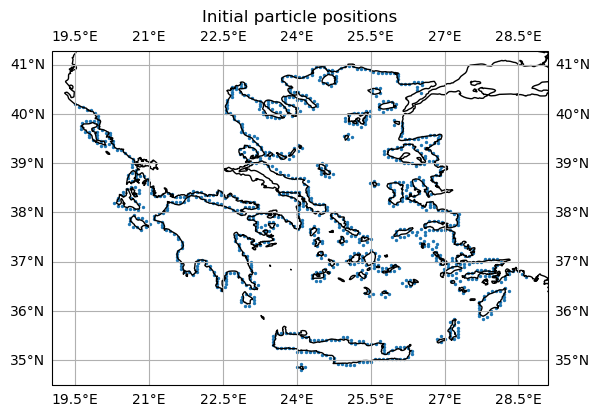

In [33]:
## Plot the particles initial positions
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(pset.lon, pset.lat, s=2, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title("Initial particle positions")
plt.show()

In [34]:
## Define the runtime, the timestepping, and the output frequency of the simulation
runtime = particle_settings['runtime']
dt_timestep = particle_settings['dt_timestep']
dt_write = particle_settings['dt_write']

## Create the particle file where output will be stored
pfile = ParticleFile('advanced_release.zarr', pset, outputdt=dt_write)

## Execute the simulation
pset.execute(kernels, runtime=runtime, dt=dt_timestep, output_file=pfile)

INFO: Output files are stored in advanced_release.zarr.
100%|██████████| 259200.0/259200.0 [01:30<00:00, 2865.40it/s]


/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


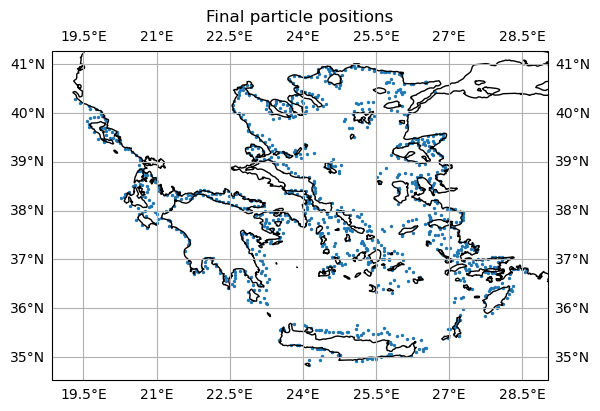

In [35]:
## Plot the particles final positions
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(pset.lon, pset.lat, s=2, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title("Final particle positions")
plt.show()

# Particle Trajectory Analysis
You can now analyse your particle sets. Rather than re-invent the wheel, we point you to the Parcels tutorial https://docs.oceanparcels.org/en/latest/examples/tutorial_output.html which explains how to read and analyse Parcels particle trajectory datasets.